In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10740483535840392211
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5736300544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3140827092688378393
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
import warnings, graphviz, optuna, pydot
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')
sns.set(style='white')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
trn = pd.read_csv('aug_train.csv')
tst = pd.read_csv('aug_test.csv')
tst_answer = np.load('jobchange_test_target_values.npy')
tst['target'] = tst_answer
trn.drop('enrollee_id', axis=1, inplace=True)
tst.drop('enrollee_id', axis=1, inplace=True)
trn['city'] = trn['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))
tst['city'] = tst['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))

# 모든 Null 값을 Missing으로 변경합니다.
for col in tst.columns:
    trn[col].fillna('Missing', inplace=True)
    tst[col].fillna('Missing', inplace=True)
    
# Missing 값의 갯수 Feature 생성
trn['num_missing'] = (trn=='Missing').sum(axis=1)
tst['num_missing'] = (tst=='Missing').sum(axis=1)
    
print(f"train data size: {trn.shape}, test data size: {tst.shape}")
trn.head(2)

train data size: (19158, 14), test data size: (2129, 14)


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,num_missing
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Missing,Missing,1,36,1.0,2
1,city_040,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,0


In [4]:
trn_info = pd.concat(
    [
        trn.dtypes,        
        trn.isnull().sum(),
        trn.isnull().sum() / trn.shape[0],
        trn.nunique(),
        tst.nunique()
    ], axis=1
)
trn_info.columns=['data_types', 'Num_of_Null', 'Null_ratio', 'Num_of_unique_values(train)', 'Num_of_unique_values(test)']
trn_info.iloc[:-1, :].style.background_gradient()
# Null값이 상당히 많습니다.

,data_types,Num_of_Null,Null_ratio,Num_of_unique_values(train),Num_of_unique_values(test)
city,object,0,0.000000,123,108
city_development_index,float64,0,0.000000,93,81
gender,object,0,0.000000,4,4
relevent_experience,object,0,0.000000,2,2
enrolled_university,object,0,0.000000,4,4
education_level,object,0,0.000000,6,6
major_discipline,object,0,0.000000,7,7
experience,object,0,0.000000,23,23
company_size,object,0,0.000000,9,9
company_type,object,0,0.000000,7,7


In [5]:
for col in trn.select_dtypes(include='object').columns:
    print(f"{col} feature의 unique value train/test 동일 여부: {sorted(trn[col].unique()) == sorted(tst[col].unique())}")
print("="*100)
# city를 빼고는 train과 test 셋의 unique values가 동일합니다.
# 문제는 test에는 있는 city가 train에 있을 경우 입니다. 혹시 모르니 확인해봅니다.
for city in tst['city'].unique():
    if city not in trn['city'].unique():
        print('warnings!') 
# 다행히 warnings가 출력되지 않았습니다. 그럼 train 데이터를 기준으로 모두 labelencoding 하겠습니다.

city feature의 unique value train/test 동일 여부: False
gender feature의 unique value train/test 동일 여부: True
relevent_experience feature의 unique value train/test 동일 여부: True
enrolled_university feature의 unique value train/test 동일 여부: True
education_level feature의 unique value train/test 동일 여부: True
major_discipline feature의 unique value train/test 동일 여부: True
experience feature의 unique value train/test 동일 여부: True
company_size feature의 unique value train/test 동일 여부: True
company_type feature의 unique value train/test 동일 여부: True
last_new_job feature의 unique value train/test 동일 여부: True


In [6]:
# 데이터 불러오기  /  labelencoding 함수 정의
def load_data():
    trn = pd.read_csv('aug_train.csv')
    tst = pd.read_csv('aug_test.csv')
    tst_answer = np.load('jobchange_test_target_values.npy')
    tst['target'] = tst_answer
    trn.drop('enrollee_id', axis=1, inplace=True)
    tst.drop('enrollee_id', axis=1, inplace=True)
    trn['city'] = trn['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))
    tst['city'] = tst['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))

    # 모든 Null 값을 Missing으로 변경합니다.
    for col in tst.columns:
        trn[col].fillna('Missing', inplace=True)
        tst[col].fillna('Missing', inplace=True)

    # Missing 값의 갯수 Feature 생성
    trn['num_missing'] = (trn=='Missing').sum(axis=1)
    tst['num_missing'] = (tst=='Missing').sum(axis=1)
    return trn, tst

def labelencoder(train, test):
    # normianl feature는 labelencoder로 처리
    norminal = ['city', 'gender', 'relevent_experience', 'major_discipline', 'company_type']
    for col in norminal:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

    # ordinal feature는 자체적으로 생성한 dictionary로 처리합니다
    ordinal = {
        'enrolled_university':{'Full time course':3, 'Part time course':2, 'no_enrollment':1, 'Missing':0},
        'education_level':{'Phd':5, 'Masters':4, 'Graduate':3, 'High School':2, 'Primary School':1, 'Missing':0},
        'experience':{
            '>20':22, '20':21, '19':20, '18':19, '17':18, '16':17, '15':16, '14':15, '13':14, '12':13, '11':12, '10':11,
            '9':10, '8':9, '7':8, '6':7, '5':6, '4':5, '3':4, '2':3, '1':2 , '<1':1, 'Missing':0
        },
        'company_size':{'10000+':8, '5000-9999':7, '1000-4999':6, '500-999':5, '100-500':4, '50-99':3, '10/49':2, '<10':1, 'Missing':0},
        'last_new_job':{'>4':6, '4':5, '3':4, '2':3, '1':2, 'never':1, 'Missing':0}
    }
    for col in ordinal:
        train[col] = train[col].map(ordinal[col])
        test[col] = test[col].map(ordinal[col])
    return train, test

In [7]:
trn, tst = load_data()
trn, tst = labelencoder(trn, tst)
features = trn.drop('target', axis=1).columns
print(trn.shape, tst.shape)
trn.head(2)

(19158, 14) (2129, 14)


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,num_missing
0,73,0.920,1,0,1,3,6,22,0,2,2,36,1.0,2
1,27,0.776,1,1,1,3,6,16,3,6,6,47,0.0,0


In [8]:
dataset_info = pd.concat(
    [
        trn.dtypes, trn.isnull().sum(), tst.dtypes, tst.isnull().sum()
    ], axis=1
)
dataset_info.columns = ['train_dtypes', 'train_Num_of_Nulls', 'test_dtypes', 'test_Num_of_Nulls']
dataset_info # 모든 feature가 numeric으로 변경되었고 Null도 없습니다. 이제 baseline model을 생성하겠습니다.

,train_dtypes,train_Num_of_Nulls,test_dtypes,test_Num_of_Nulls
city,int32,0,int32,0
city_development_index,float64,0,float64,0
gender,int32,0,int32,0
relevent_experience,int32,0,int32,0
enrolled_university,int64,0,int64,0
education_level,int64,0,int64,0
major_discipline,int32,0,int32,0
experience,int64,0,int64,0
company_size,int64,0,int64,0
company_type,int32,0,int32,0


In [9]:
# DecisionTree 시각화 부터 시작합니다.
features = trn.drop('target', axis=1).columns
# 먼저 random 모델의 성능을 확인합니다. 단순하게 모든 target을 0으로 예측하면 정확도는
print(f"모든 데이터를 0으로 예측하면 train dataset의 정확도는: {format((trn['target'].value_counts() / trn.shape[0]).values[0], '.1%')}")
print(f"모든 데이터를 0으로 예측하면 test dataset의 정확도는: {format((tst['target'].value_counts() / tst.shape[0]).values[0], '.1%')}")
# 최소한 아래 정확도는 넘겨야 합니다.

모든 데이터를 0으로 예측하면 train dataset의 정확도는: 75.1%
모든 데이터를 0으로 예측하면 test dataset의 정확도는: 72.9%


accuracy_score in train dataset: 79.2%
accuracy_score in test dataset: 78.8%
log_loss in test dataset: 0.4963
roc_auc_score in test dataset: 0.7248


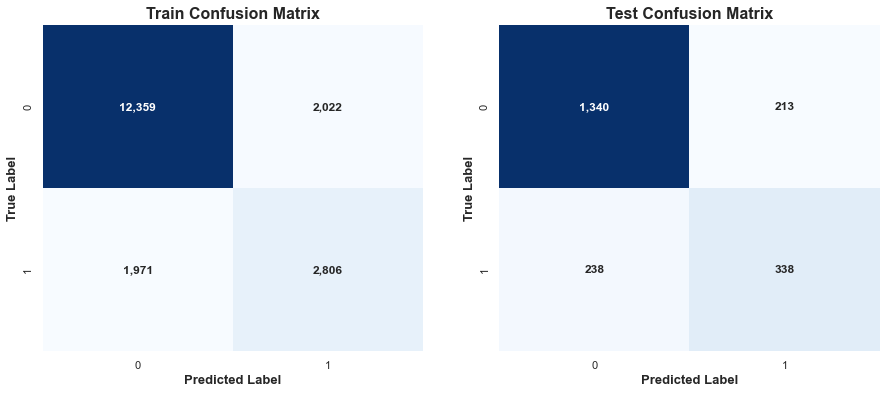

In [10]:
# 먼저 트리 시각화를 위해 decisiontree 모델을 사용합니다.
model = DecisionTreeClassifier(max_depth=5)
model.fit(trn[features], trn['target'])
trn_pred = model.predict(trn[features])
tst_pred = model.predict(tst[features])
tst_pred_proba = model.predict_proba(tst[features])
print(f"accuracy_score in train dataset: {accuracy_score(trn.target, trn_pred):.1%}")
print(f"accuracy_score in test dataset: {accuracy_score(tst.target, tst_pred):.1%}")
print(f"log_loss in test dataset: {log_loss(tst.target, tst_pred_proba):.4f}")
print(f"roc_auc_score in test dataset: {roc_auc_score(tst.target, tst_pred):.4f}")
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)
sns.heatmap(
    confusion_matrix(trn.target, trn_pred), ax=axes[0], annot=True, fmt=",", cbar=False, cmap='Blues',
    annot_kws={'fontweight':'bold'}
)
sns.heatmap(
    confusion_matrix(tst.target, tst_pred), ax=axes[1], annot=True, fmt=",", cbar=False, cmap='Blues',
    annot_kws={'fontweight':'bold'}
)
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.show()
# 아주 약간 높습니다. 트리 시각화를 위해 최적의 max_depth를 찾아보겠습니다.

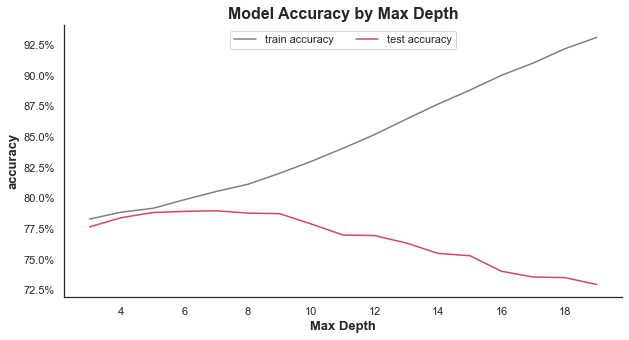

In [11]:
# max_depth에 따른 정확도를 시각화 합니다.
trn_acc_list, tst_acc_list = [], []
for max_depth in range(3, 20):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(trn[features], trn['target'])
    trn_acc = accuracy_score(model.predict(trn[features]), trn.target)
    tst_acc = accuracy_score(model.predict(tst[features]), tst.target)    
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(3, 20), trn_acc_list, label='train accuracy', color='grey')
ax.plot(range(3, 20), tst_acc_list, label='test accuracy', color="#d1495b")
ax.set_xlabel('Max Depth')
ax.set_ylabel('accuracy')
ax.set_yticklabels(list(format(y, ".1%") for y in ax.get_yticks()))
ax.legend(loc='upper center', ncol=2)
ax.set_title('Model Accuracy by Max Depth')
plt.show()
# max_depth 6부터 과적합입니다. 이제 max_depth 6의 트리모델을 시각화 합니다.

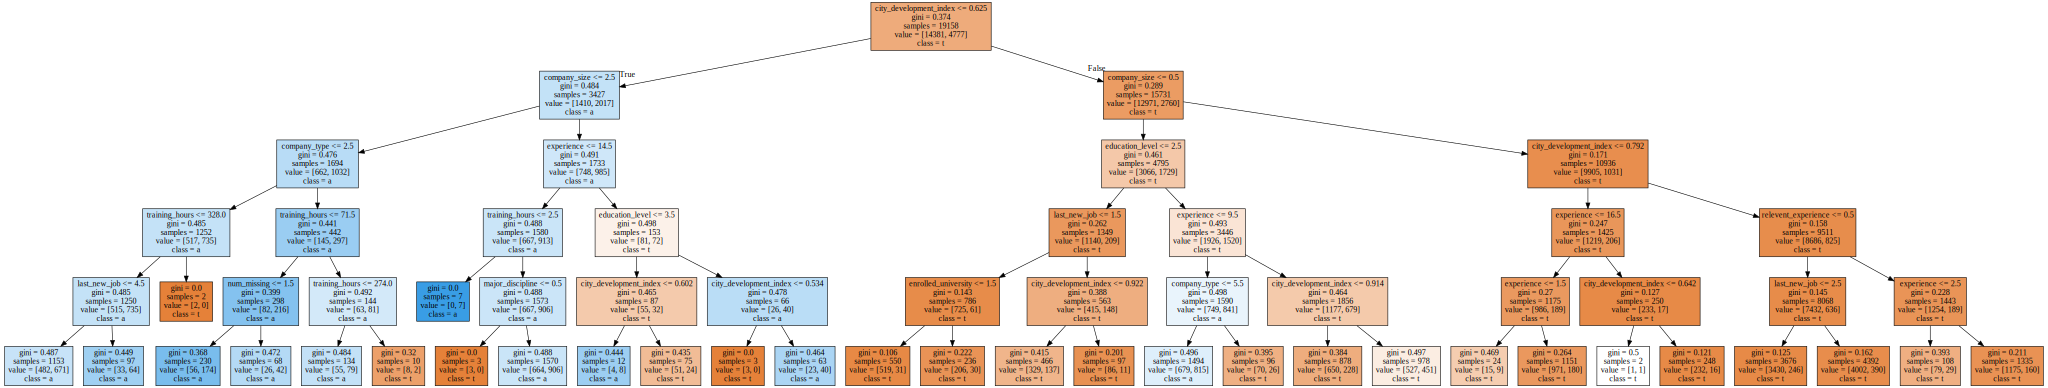

In [12]:
# DecisionTree 시각화, Max Depth는 5로 설정합니다.
model = DecisionTreeClassifier(max_depth=5)
model.fit(trn[features], trn['target'])

export_graphviz(
    model, out_file="basetree.dot", class_names='target', feature_names=features,
    filled=True, impurity=True
) #export_graphviz로 dot 파일을 생성한 후 

(graph,) = pydot.graph_from_dot_file('basetree.dot')
graph.write_png('basetree_maxdepth_5.png') #dot to png

with open("basetree.dot") as f:
    dot_graph = f.read() #위의 dot파일을 읽고
graphviz.Source(dot_graph) #graphviz.Source()로 그립니다.

In [13]:
def make_result_df(model_names, pred_proba_list):
    data = np.zeros((len(model_names), 3))
    for idx, pred in enumerate(pred_proba_list):
        data[idx, :] = [
            accuracy_score(tst.target, np.argmax(pred, axis=1)),
            log_loss(tst.target, pred), roc_auc_score(tst.target, np.argmax(pred, axis=1))
        ]
    data = pd.DataFrame(index=model_names, data=data, columns=['acc', 'log_loss', 'roc_score'])
    return data

In [14]:
# tree 시각화를 끝냈으니 이제 본격적으로 모델을 생성해보겠습니다.
# Randomforest, XGBoost, LightGBM의 모델 성능을 비교해봅니다. 
models = [
    RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=5),
    XGBClassifier(n_jobs=-1, max_depth=5),
    LGBMClassifier(n_jobs=-1)
]
pred_proba_list = []
for model in models:
    result = cross_val_score(model, X=trn[features], y=trn.target, cv=5, scoring='neg_log_loss')
    model.fit(trn[features], trn.target)
    tst_preds = model.predict(tst[features])
    pred_proba_list.append(model.predict_proba(tst[features]))

model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)']
result = make_result_df(model_names, pred_proba_list)
result

[10:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,acc,log_loss,roc_score
RandomForest,0.782997,0.462287,0.676504
XGBClassifier,0.774542,0.472222,0.694191
LGBMClassifier(base),0.783466,0.460133,0.719422


In [15]:
# 이번에는 LightGBM 모델을 튜닝해보겠습니다.
def lgbm_object(trial:optuna.Trial, trn):
    X_trn, X_vld, y_trn, y_vld = train_test_split(trn[features], trn.target, test_size=0.2, random_state=0)
    params = {
        # 각 항목에 대해서 자세히 설명은 구글을 참고해주시기 바랍니다. feature가 몇개 없으므로 gamma, reg_lambda와 reg_alpha는 사용하지 않겠습니다.
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 7),
        'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
        'subsample' : trial.suggest_float('subsample', 0.5, 1),                
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
        'max_bin' : trial.suggest_int('max_bin', 200, 500),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),  
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
    }
    model = LGBMClassifier(**params, seed=0, n_jobs=-1)
    model.fit(X_trn, y_trn, verbose=0)
    return log_loss(y_vld, model.predict_proba(X_vld)) # 모델의 최종 결과값을 반환합니다.
# 평가지표가 log_loss이므로 direction은 minimize 입니다.
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(lambda trial : lgbm_object(trial, trn), n_trials=1000, n_jobs=-1)    

[I 2021-09-30 10:20:28,258] A new study created in memory with name: no-name-4b0147b1-8379-4701-88f2-bc1edde78d58
[I 2021-09-30 10:20:30,090] Trial 23 finished with value: 0.4362609542369093 and parameters: {'learning_rate': 0.021394916739290875, 'min_child_weight': 7, 'min_child_samples': 42, 'subsample': 0.6910870744968434, 'colsample_bytree': 0.6961977087538245, 'num_leaves': 9, 'max_bin': 271, 'reg_alpha': 0.985697638504845, 'reg_lambda': 0.7863635893335451, 'n_estimators': 410}. Best is trial 23 with value: 0.4362609542369093.
[I 2021-09-30 10:20:32,272] Trial 10 finished with value: 0.45221214745063526 and parameters: {'learning_rate': 0.08849279065684959, 'min_child_weight': 5, 'min_child_samples': 63, 'subsample': 0.8327369079685889, 'colsample_bytree': 0.5978769382242003, 'num_leaves': 78, 'max_bin': 232, 'reg_alpha': 0.5438119336581059, 'reg_lambda': 0.38187137452389375, 'n_estimators': 122}. Best is trial 23 with value: 0.4362609542369093.
[I 2021-09-30 10:20:32,690] Trial 2

[I 2021-09-30 10:20:39,882] Trial 22 finished with value: 0.46171321821149974 and parameters: {'learning_rate': 0.04244549917613283, 'min_child_weight': 4, 'min_child_samples': 47, 'subsample': 0.8103546747541431, 'colsample_bytree': 0.7938042924821134, 'num_leaves': 83, 'max_bin': 423, 'reg_alpha': 0.2496827174098255, 'reg_lambda': 0.9346817869466422, 'n_estimators': 366}. Best is trial 23 with value: 0.4362609542369093.
[I 2021-09-30 10:20:40,259] Trial 1 finished with value: 0.4794639482949669 and parameters: {'learning_rate': 0.07236228639781968, 'min_child_weight': 3, 'min_child_samples': 19, 'subsample': 0.5167842102903091, 'colsample_bytree': 0.6615253885770753, 'num_leaves': 68, 'max_bin': 231, 'reg_alpha': 0.17722270380278238, 'reg_lambda': 0.5838724923239891, 'n_estimators': 415}. Best is trial 23 with value: 0.4362609542369093.
[I 2021-09-30 10:20:40,521] Trial 36 finished with value: 0.4372729543279935 and parameters: {'learning_rate': 0.03249544764750561, 'min_child_weight

[I 2021-09-30 10:20:48,489] Trial 9 finished with value: 0.49880485112571854 and parameters: {'learning_rate': 0.09310171744661667, 'min_child_weight': 2, 'min_child_samples': 84, 'subsample': 0.6911598903785124, 'colsample_bytree': 0.5372366873836145, 'num_leaves': 209, 'max_bin': 246, 'reg_alpha': 0.8189697653256174, 'reg_lambda': 0.5830485159444802, 'n_estimators': 410}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:20:48,901] Trial 48 finished with value: 0.43558727642652395 and parameters: {'learning_rate': 0.010111128905449171, 'min_child_weight': 6, 'min_child_samples': 31, 'subsample': 0.6821557665825326, 'colsample_bytree': 0.6310218961014109, 'num_leaves': 27, 'max_bin': 288, 'reg_alpha': 0.8211151239278867, 'reg_lambda': 0.600657060806099, 'n_estimators': 487}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:20:48,963] Trial 49 finished with value: 0.4391168364310811 and parameters: {'learning_rate': 0.02587639261309271, 'min_child_wei

[I 2021-09-30 10:20:59,907] Trial 62 finished with value: 0.43780588212981286 and parameters: {'learning_rate': 0.011829837272221241, 'min_child_weight': 5, 'min_child_samples': 69, 'subsample': 0.7671172137769098, 'colsample_bytree': 0.5834822538672103, 'num_leaves': 58, 'max_bin': 388, 'reg_alpha': 0.5394269512147312, 'reg_lambda': 0.5361817692894084, 'n_estimators': 435}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:00,379] Trial 77 finished with value: 0.4360066799046425 and parameters: {'learning_rate': 0.015922473034094227, 'min_child_weight': 7, 'min_child_samples': 16, 'subsample': 0.6307579690141661, 'colsample_bytree': 0.6125737618039933, 'num_leaves': 13, 'max_bin': 248, 'reg_alpha': 0.6525171070672536, 'reg_lambda': 0.7288468408011004, 'n_estimators': 492}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:00,695] Trial 53 finished with value: 0.44276728525009884 and parameters: {'learning_rate': 0.018889559305601086, 'min_child_

[I 2021-09-30 10:21:06,074] Trial 97 finished with value: 0.46430808692382086 and parameters: {'learning_rate': 0.014365630688137225, 'min_child_weight': 7, 'min_child_samples': 5, 'subsample': 0.5675667794791779, 'colsample_bytree': 0.9361406287971633, 'num_leaves': 2, 'max_bin': 237, 'reg_alpha': 0.6672406917782033, 'reg_lambda': 0.8770882407109785, 'n_estimators': 470}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:06,548] Trial 69 finished with value: 0.4418054424069996 and parameters: {'learning_rate': 0.01879242161795298, 'min_child_weight': 5, 'min_child_samples': 19, 'subsample': 0.7752396415388947, 'colsample_bytree': 0.6043051655848335, 'num_leaves': 58, 'max_bin': 351, 'reg_alpha': 0.6440074876443005, 'reg_lambda': 0.5369954173464182, 'n_estimators': 433}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:06,633] Trial 99 finished with value: 0.44143866494725337 and parameters: {'learning_rate': 0.014333267208459103, 'min_child_wei

[I 2021-09-30 10:21:13,112] Trial 96 finished with value: 0.43815649452735983 and parameters: {'learning_rate': 0.014179183455144352, 'min_child_weight': 7, 'min_child_samples': 5, 'subsample': 0.5830452957470271, 'colsample_bytree': 0.9279333539032159, 'num_leaves': 37, 'max_bin': 239, 'reg_alpha': 0.667855874453289, 'reg_lambda': 0.8835685500181173, 'n_estimators': 470}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:13,193] Trial 94 finished with value: 0.4374760322345236 and parameters: {'learning_rate': 0.015011799653277758, 'min_child_weight': 7, 'min_child_samples': 6, 'subsample': 0.6012135879435297, 'colsample_bytree': 0.6059965942671889, 'num_leaves': 37, 'max_bin': 262, 'reg_alpha': 0.7775603702225585, 'reg_lambda': 0.735346928332717, 'n_estimators': 468}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:13,304] Trial 93 finished with value: 0.4374331992695707 and parameters: {'learning_rate': 0.014137656444869596, 'min_child_weigh

[I 2021-09-30 10:21:17,342] Trial 118 finished with value: 0.43504299880396796 and parameters: {'learning_rate': 0.012069038092650928, 'min_child_weight': 6, 'min_child_samples': 13, 'subsample': 0.5220162055374739, 'colsample_bytree': 0.6503246772715355, 'num_leaves': 19, 'max_bin': 264, 'reg_alpha': 0.7715030822555243, 'reg_lambda': 0.7793611889828517, 'n_estimators': 376}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:17,483] Trial 108 finished with value: 0.4380713890223297 and parameters: {'learning_rate': 0.015321507227144024, 'min_child_weight': 7, 'min_child_samples': 13, 'subsample': 0.6758984043591932, 'colsample_bytree': 0.9808633422525133, 'num_leaves': 34, 'max_bin': 261, 'reg_alpha': 0.6752323149568246, 'reg_lambda': 0.7184403417251242, 'n_estimators': 476}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:17,703] Trial 119 finished with value: 0.4374549292433404 and parameters: {'learning_rate': 0.024992701300447444, 'min_chil

[I 2021-09-30 10:21:21,149] Trial 133 finished with value: 0.4358798528723834 and parameters: {'learning_rate': 0.02534120819216667, 'min_child_weight': 6, 'min_child_samples': 26, 'subsample': 0.6801459384939362, 'colsample_bytree': 0.6453548443392215, 'num_leaves': 20, 'max_bin': 293, 'reg_alpha': 0.9204895783662794, 'reg_lambda': 0.9089708634609982, 'n_estimators': 368}. Best is trial 40 with value: 0.43497036990241844.
[I 2021-09-30 10:21:21,497] Trial 134 finished with value: 0.43492394302406745 and parameters: {'learning_rate': 0.012220057916396946, 'min_child_weight': 6, 'min_child_samples': 26, 'subsample': 0.6627043798175869, 'colsample_bytree': 0.6472301731160132, 'num_leaves': 20, 'max_bin': 227, 'reg_alpha': 0.6885067880272143, 'reg_lambda': 0.7167990768377428, 'n_estimators': 371}. Best is trial 134 with value: 0.43492394302406745.
[I 2021-09-30 10:21:21,577] Trial 135 finished with value: 0.43504487854372126 and parameters: {'learning_rate': 0.011736372439609491, 'min_chi

[I 2021-09-30 10:21:24,239] Trial 164 finished with value: 0.43820940413591436 and parameters: {'learning_rate': 0.010614658673305721, 'min_child_weight': 6, 'min_child_samples': 17, 'subsample': 0.5562859624408236, 'colsample_bytree': 0.6770438867756283, 'num_leaves': 7, 'max_bin': 216, 'reg_alpha': 0.7128387109320077, 'reg_lambda': 0.8297945238637919, 'n_estimators': 382}. Best is trial 145 with value: 0.4348657344038254.
[I 2021-09-30 10:21:24,695] Trial 150 finished with value: 0.43511063523112625 and parameters: {'learning_rate': 0.011622192542643081, 'min_child_weight': 6, 'min_child_samples': 10, 'subsample': 0.5484965323618255, 'colsample_bytree': 0.6729843303086877, 'num_leaves': 25, 'max_bin': 216, 'reg_alpha': 0.7111363524503869, 'reg_lambda': 0.8221962756539075, 'n_estimators': 381}. Best is trial 145 with value: 0.4348657344038254.
[I 2021-09-30 10:21:25,093] Trial 149 finished with value: 0.43517479716179464 and parameters: {'learning_rate': 0.01212035020125062, 'min_chil

[I 2021-09-30 10:21:30,960] Trial 162 finished with value: 0.4360070976120081 and parameters: {'learning_rate': 0.011682148684694972, 'min_child_weight': 6, 'min_child_samples': 10, 'subsample': 0.5542625490680124, 'colsample_bytree': 0.6732901557862826, 'num_leaves': 44, 'max_bin': 215, 'reg_alpha': 0.7102321451145205, 'reg_lambda': 0.8417168886166015, 'n_estimators': 382}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:31,152] Trial 166 finished with value: 0.4358297627281193 and parameters: {'learning_rate': 0.010797298498146868, 'min_child_weight': 6, 'min_child_samples': 31, 'subsample': 0.5088595569958796, 'colsample_bytree': 0.6785712537438185, 'num_leaves': 45, 'max_bin': 231, 'reg_alpha': 0.7121256676226314, 'reg_lambda': 0.8401878520344622, 'n_estimators': 356}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:31,232] Trial 163 finished with value: 0.4359064380152587 and parameters: {'learning_rate': 0.010947958529927897, 'min_child

[I 2021-09-30 10:21:34,928] Trial 179 finished with value: 0.4358185480415159 and parameters: {'learning_rate': 0.010060435050355298, 'min_child_weight': 6, 'min_child_samples': 21, 'subsample': 0.5602384491361886, 'colsample_bytree': 0.6913894216358751, 'num_leaves': 47, 'max_bin': 231, 'reg_alpha': 0.8012281286430365, 'reg_lambda': 0.9184403222481679, 'n_estimators': 357}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:35,004] Trial 204 finished with value: 0.4353517998922254 and parameters: {'learning_rate': 0.016548158666085576, 'min_child_weight': 6, 'min_child_samples': 31, 'subsample': 0.5335944238195226, 'colsample_bytree': 0.6330533249721447, 'num_leaves': 15, 'max_bin': 279, 'reg_alpha': 0.653877740368999, 'reg_lambda': 0.7981917071669484, 'n_estimators': 332}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:35,080] Trial 180 finished with value: 0.44457378193725705 and parameters: {'learning_rate': 0.03889699594324272, 'min_child_

[I 2021-09-30 10:21:47,510] Trial 228 finished with value: 0.4352263759099016 and parameters: {'learning_rate': 0.013256134124841473, 'min_child_weight': 6, 'min_child_samples': 25, 'subsample': 0.654569246616387, 'colsample_bytree': 0.6432096539501924, 'num_leaves': 28, 'max_bin': 373, 'reg_alpha': 0.048621187172278965, 'reg_lambda': 0.8727278772941276, 'n_estimators': 347}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:47,885] Trial 218 finished with value: 0.4393139058740525 and parameters: {'learning_rate': 0.013499588822208253, 'min_child_weight': 6, 'min_child_samples': 24, 'subsample': 0.656724813695927, 'colsample_bytree': 0.6439144807655245, 'num_leaves': 81, 'max_bin': 224, 'reg_alpha': 0.6856696013386556, 'reg_lambda': 0.858866938096761, 'n_estimators': 372}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:49,380] Trial 177 finished with value: 0.44075705846294133 and parameters: {'learning_rate': 0.01003711102386695, 'min_child_

[I 2021-09-30 10:21:57,108] Trial 241 finished with value: 0.4356115403759297 and parameters: {'learning_rate': 0.01564011104436336, 'min_child_weight': 3, 'min_child_samples': 15, 'subsample': 0.6352069019265775, 'colsample_bytree': 0.6133111480671206, 'num_leaves': 24, 'max_bin': 366, 'reg_alpha': 0.13662326430470548, 'reg_lambda': 0.11640447919561639, 'n_estimators': 375}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:57,779] Trial 203 finished with value: 0.45181344384972616 and parameters: {'learning_rate': 0.020298767266626112, 'min_child_weight': 6, 'min_child_samples': 31, 'subsample': 0.5342936023554703, 'colsample_bytree': 0.635634234823206, 'num_leaves': 201, 'max_bin': 498, 'reg_alpha': 0.6517994825005048, 'reg_lambda': 0.2977474600690721, 'n_estimators': 328}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:21:57,957] Trial 245 finished with value: 0.4354246366793737 and parameters: {'learning_rate': 0.015381119890243036, 'min_chi

[I 2021-09-30 10:22:05,404] Trial 210 finished with value: 0.44546427898738034 and parameters: {'learning_rate': 0.013433077553022458, 'min_child_weight': 6, 'min_child_samples': 8, 'subsample': 0.7333693524245025, 'colsample_bytree': 0.6391599091011961, 'num_leaves': 209, 'max_bin': 241, 'reg_alpha': 0.6541901569610542, 'reg_lambda': 0.7972007326655358, 'n_estimators': 392}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:05,463] Trial 261 finished with value: 0.43500578871196227 and parameters: {'learning_rate': 0.010030588880820993, 'min_child_weight': 6, 'min_child_samples': 16, 'subsample': 0.6431897967677663, 'colsample_bytree': 0.6229027896048456, 'num_leaves': 19, 'max_bin': 383, 'reg_alpha': 0.02351062015753915, 'reg_lambda': 0.17162554886916004, 'n_estimators': 387}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:05,689] Trial 258 finished with value: 0.43598652886928924 and parameters: {'learning_rate': 0.013272373989522003, 'min_

[I 2021-09-30 10:22:08,557] Trial 269 finished with value: 0.4349875699385127 and parameters: {'learning_rate': 0.011518225590433322, 'min_child_weight': 6, 'min_child_samples': 13, 'subsample': 0.7085098961535297, 'colsample_bytree': 0.626049543400027, 'num_leaves': 18, 'max_bin': 373, 'reg_alpha': 0.23591875410865487, 'reg_lambda': 0.8530707958773726, 'n_estimators': 388}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:08,949] Trial 224 finished with value: 0.44424807981732345 and parameters: {'learning_rate': 0.013492743140675823, 'min_child_weight': 6, 'min_child_samples': 24, 'subsample': 0.695410337769513, 'colsample_bytree': 0.6138673377760738, 'num_leaves': 202, 'max_bin': 225, 'reg_alpha': 0.6665410959926058, 'reg_lambda': 0.8740931368685242, 'n_estimators': 370}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:08,968] Trial 277 finished with value: 0.4415037787219145 and parameters: {'learning_rate': 0.011452901145775097, 'min_chil

[I 2021-09-30 10:22:14,912] Trial 299 finished with value: 0.43532823075090693 and parameters: {'learning_rate': 0.011879027365516296, 'min_child_weight': 5, 'min_child_samples': 8, 'subsample': 0.6815436374954915, 'colsample_bytree': 0.8982476389868648, 'num_leaves': 11, 'max_bin': 378, 'reg_alpha': 0.2412422649573679, 'reg_lambda': 0.08722936118687055, 'n_estimators': 399}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:14,973] Trial 300 finished with value: 0.4354612073810109 and parameters: {'learning_rate': 0.01493685258445439, 'min_child_weight': 5, 'min_child_samples': 7, 'subsample': 0.6252446371226149, 'colsample_bytree': 0.6059724283670832, 'num_leaves': 12, 'max_bin': 380, 'reg_alpha': 0.2744955480533081, 'reg_lambda': 0.08260490986540162, 'n_estimators': 397}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:15,310] Trial 306 finished with value: 0.43578164543248227 and parameters: {'learning_rate': 0.012235373375412298, 'min_chil

[I 2021-09-30 10:22:20,296] Trial 315 finished with value: 0.4354917159430409 and parameters: {'learning_rate': 0.014660618295023997, 'min_child_weight': 4, 'min_child_samples': 100, 'subsample': 0.657341016830168, 'colsample_bytree': 0.6670696104697372, 'num_leaves': 26, 'max_bin': 367, 'reg_alpha': 0.12369103291480159, 'reg_lambda': 0.9633709906100509, 'n_estimators': 365}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:20,379] Trial 318 finished with value: 0.4351566709117155 and parameters: {'learning_rate': 0.015044758668159339, 'min_child_weight': 4, 'min_child_samples': 60, 'subsample': 0.6573464652221132, 'colsample_bytree': 0.6659213533770685, 'num_leaves': 26, 'max_bin': 369, 'reg_alpha': 0.11864708659345916, 'reg_lambda': 0.1730927609240739, 'n_estimators': 364}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:20,535] Trial 316 finished with value: 0.43569233611116953 and parameters: {'learning_rate': 0.01417567777615799, 'min_chi

[I 2021-09-30 10:22:27,322] Trial 332 finished with value: 0.4357452947945689 and parameters: {'learning_rate': 0.012863419299116089, 'min_child_weight': 6, 'min_child_samples': 14, 'subsample': 0.6458043941905298, 'colsample_bytree': 0.6537045281805054, 'num_leaves': 35, 'max_bin': 272, 'reg_alpha': 0.024549997856667886, 'reg_lambda': 0.18173562431056886, 'n_estimators': 387}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:27,781] Trial 336 finished with value: 0.43684945289622695 and parameters: {'learning_rate': 0.019006974185375097, 'min_child_weight': 6, 'min_child_samples': 21, 'subsample': 0.634041274079961, 'colsample_bytree': 0.6526102040947822, 'num_leaves': 36, 'max_bin': 271, 'reg_alpha': 0.01736643777113482, 'reg_lambda': 0.35355967882529254, 'n_estimators': 374}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:27,951] Trial 335 finished with value: 0.4368150483151729 and parameters: {'learning_rate': 0.017916230336005087, 'min_

[I 2021-09-30 10:22:35,163] Trial 356 finished with value: 0.4349214164190315 and parameters: {'learning_rate': 0.010138371726866295, 'min_child_weight': 1, 'min_child_samples': 11, 'subsample': 0.6878830147367408, 'colsample_bytree': 0.8006093099591555, 'num_leaves': 20, 'max_bin': 375, 'reg_alpha': 0.6650559982701446, 'reg_lambda': 0.9097706895038137, 'n_estimators': 407}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:35,669] Trial 359 finished with value: 0.43966824901092955 and parameters: {'learning_rate': 0.04205317699056607, 'min_child_weight': 6, 'min_child_samples': 97, 'subsample': 0.6991126340432949, 'colsample_bytree': 0.6254515301928562, 'num_leaves': 21, 'max_bin': 304, 'reg_alpha': 0.669572475047338, 'reg_lambda': 0.9991012770835471, 'n_estimators': 356}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:36,061] Trial 247 finished with value: 0.4527720823640864 and parameters: {'learning_rate': 0.01502586956480624, 'min_child_w

[I 2021-09-30 10:22:43,006] Trial 311 finished with value: 0.44739549108457194 and parameters: {'learning_rate': 0.015593623710165871, 'min_child_weight': 6, 'min_child_samples': 17, 'subsample': 0.653041754227984, 'colsample_bytree': 0.6099987874220842, 'num_leaves': 160, 'max_bin': 378, 'reg_alpha': 0.12392373011113328, 'reg_lambda': 0.9594528959495054, 'n_estimators': 367}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:43,089] Trial 380 finished with value: 0.43720731272755625 and parameters: {'learning_rate': 0.01211438202349788, 'min_child_weight': 2, 'min_child_samples': 29, 'subsample': 0.6861924239957028, 'colsample_bytree': 0.7083129179515579, 'num_leaves': 8, 'max_bin': 288, 'reg_alpha': 0.6924343952243556, 'reg_lambda': 0.9404189900386436, 'n_estimators': 341}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:43,197] Trial 372 finished with value: 0.43715288560998894 and parameters: {'learning_rate': 0.016329313654874552, 'min_chi

[I 2021-09-30 10:22:46,839] Trial 379 finished with value: 0.4368565370043796 and parameters: {'learning_rate': 0.016784676578291337, 'min_child_weight': 1, 'min_child_samples': 30, 'subsample': 0.6861796047523896, 'colsample_bytree': 0.7874764220372398, 'num_leaves': 31, 'max_bin': 303, 'reg_alpha': 0.6346901212084707, 'reg_lambda': 0.8263476502096461, 'n_estimators': 407}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:47,285] Trial 390 finished with value: 0.43514499215787505 and parameters: {'learning_rate': 0.01186979226529302, 'min_child_weight': 2, 'min_child_samples': 25, 'subsample': 0.6888595611403818, 'colsample_bytree': 0.7577883433003431, 'num_leaves': 14, 'max_bin': 291, 'reg_alpha': 0.7229963745302206, 'reg_lambda': 0.2680349370061682, 'n_estimators': 390}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:47,456] Trial 391 finished with value: 0.4350129593662412 and parameters: {'learning_rate': 0.012130249258927285, 'min_child

[I 2021-09-30 10:22:51,479] Trial 422 finished with value: 0.4580834094028164 and parameters: {'learning_rate': 0.013930599183221799, 'min_child_weight': 6, 'min_child_samples': 25, 'subsample': 0.5249968859250475, 'colsample_bytree': 0.9693220371940753, 'num_leaves': 3, 'max_bin': 429, 'reg_alpha': 0.6524551579954418, 'reg_lambda': 0.7716880044894703, 'n_estimators': 188}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:51,522] Trial 415 finished with value: 0.43498333028083275 and parameters: {'learning_rate': 0.01418288784064575, 'min_child_weight': 6, 'min_child_samples': 21, 'subsample': 0.7083429163084474, 'colsample_bytree': 0.8996680650415969, 'num_leaves': 22, 'max_bin': 346, 'reg_alpha': 0.6552933089045602, 'reg_lambda': 0.7435388653133677, 'n_estimators': 230}. Best is trial 175 with value: 0.4347499065662622.
[I 2021-09-30 10:22:51,621] Trial 421 finished with value: 0.4502685614618416 and parameters: {'learning_rate': 0.01420066469904918, 'min_child_w

[I 2021-09-30 10:22:55,845] Trial 431 finished with value: 0.437153973289708 and parameters: {'learning_rate': 0.010197332497312535, 'min_child_weight': 6, 'min_child_samples': 57, 'subsample': 0.5002014785183954, 'colsample_bytree': 0.9576574015238595, 'num_leaves': 27, 'max_bin': 464, 'reg_alpha': 0.7520947635683864, 'reg_lambda': 0.8719822388402774, 'n_estimators': 215}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:22:56,000] Trial 427 finished with value: 0.4424803883580825 and parameters: {'learning_rate': 0.03665375707662531, 'min_child_weight': 6, 'min_child_samples': 75, 'subsample': 0.7746387926666075, 'colsample_bytree': 0.8299568406014981, 'num_leaves': 25, 'max_bin': 324, 'reg_alpha': 0.14035825519483947, 'reg_lambda': 0.8696935285459486, 'n_estimators': 362}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:22:56,087] Trial 425 finished with value: 0.435122856445629 and parameters: {'learning_rate': 0.01989207889263095, 'min_child_we

[I 2021-09-30 10:23:00,538] Trial 449 finished with value: 0.4361703098078905 and parameters: {'learning_rate': 0.015421218001325319, 'min_child_weight': 6, 'min_child_samples': 49, 'subsample': 0.7920501274012346, 'colsample_bytree': 0.7693135864699268, 'num_leaves': 40, 'max_bin': 395, 'reg_alpha': 0.710176634520594, 'reg_lambda': 0.7124075227278487, 'n_estimators': 151}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:00,937] Trial 370 finished with value: 0.44280421734337716 and parameters: {'learning_rate': 0.013391945655535895, 'min_child_weight': 6, 'min_child_samples': 23, 'subsample': 0.6931692268396904, 'colsample_bytree': 0.6849100684813653, 'num_leaves': 122, 'max_bin': 219, 'reg_alpha': 0.6321490459221593, 'reg_lambda': 0.8204385726334414, 'n_estimators': 406}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:00,998] Trial 440 finished with value: 0.44232061974057363 and parameters: {'learning_rate': 0.014282502216890727, 'min_chi

[I 2021-09-30 10:23:06,388] Trial 464 finished with value: 0.4352694462179495 and parameters: {'learning_rate': 0.017954206318911564, 'min_child_weight': 6, 'min_child_samples': 52, 'subsample': 0.5218693003343918, 'colsample_bytree': 0.7319422146955946, 'num_leaves': 34, 'max_bin': 440, 'reg_alpha': 0.7401498037718569, 'reg_lambda': 0.7698113180252244, 'n_estimators': 282}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:06,579] Trial 453 finished with value: 0.4370586753619384 and parameters: {'learning_rate': 0.017498593285759326, 'min_child_weight': 6, 'min_child_samples': 52, 'subsample': 0.514879584721297, 'colsample_bytree': 0.7817113228774751, 'num_leaves': 40, 'max_bin': 414, 'reg_alpha': 0.8425696293908167, 'reg_lambda': 0.7503401491354247, 'n_estimators': 354}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:06,851] Trial 462 finished with value: 0.43681184781961485 and parameters: {'learning_rate': 0.01741812129261739, 'min_child_

[I 2021-09-30 10:23:11,849] Trial 480 finished with value: 0.4346605212691021 and parameters: {'learning_rate': 0.013154613993314789, 'min_child_weight': 6, 'min_child_samples': 54, 'subsample': 0.5273307066347195, 'colsample_bytree': 0.7494699408605782, 'num_leaves': 29, 'max_bin': 464, 'reg_alpha': 0.8533593412266461, 'reg_lambda': 0.3223621517786448, 'n_estimators': 294}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:11,876] Trial 476 finished with value: 0.4350223302331922 and parameters: {'learning_rate': 0.013345283442367805, 'min_child_weight': 6, 'min_child_samples': 49, 'subsample': 0.5231958615978423, 'colsample_bytree': 0.9978991581938508, 'num_leaves': 33, 'max_bin': 479, 'reg_alpha': 0.8573299976724331, 'reg_lambda': 0.30399100949159863, 'n_estimators': 317}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:12,154] Trial 483 finished with value: 0.4491075369495821 and parameters: {'learning_rate': 0.07629687518426022, 'min_child

[I 2021-09-30 10:23:15,678] Trial 494 finished with value: 0.4349739499511531 and parameters: {'learning_rate': 0.012783028296622267, 'min_child_weight': 6, 'min_child_samples': 56, 'subsample': 0.5447613608303958, 'colsample_bytree': 0.9951835534498117, 'num_leaves': 28, 'max_bin': 423, 'reg_alpha': 0.5223529899784445, 'reg_lambda': 0.9769818943667388, 'n_estimators': 303}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:15,811] Trial 502 finished with value: 0.4357053814684486 and parameters: {'learning_rate': 0.010079966986132961, 'min_child_weight': 7, 'min_child_samples': 45, 'subsample': 0.5402331586982533, 'colsample_bytree': 0.9810760378244724, 'num_leaves': 27, 'max_bin': 475, 'reg_alpha': 0.9077633240975033, 'reg_lambda': 0.9815024814667658, 'n_estimators': 244}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:15,836] Trial 501 finished with value: 0.43527032620206035 and parameters: {'learning_rate': 0.011838648256070826, 'min_chil

[I 2021-09-30 10:23:20,220] Trial 525 finished with value: 0.4343827110638463 and parameters: {'learning_rate': 0.015316756847467094, 'min_child_weight': 6, 'min_child_samples': 46, 'subsample': 0.8715148775667617, 'colsample_bytree': 0.9864523520344237, 'num_leaves': 23, 'max_bin': 431, 'reg_alpha': 0.8375169884405421, 'reg_lambda': 0.8354532237666309, 'n_estimators': 283}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:20,278] Trial 514 finished with value: 0.4355888654749384 and parameters: {'learning_rate': 0.015865804809283825, 'min_child_weight': 7, 'min_child_samples': 45, 'subsample': 0.8417969774539238, 'colsample_bytree': 0.9735067477414071, 'num_leaves': 44, 'max_bin': 486, 'reg_alpha': 0.8463602025124293, 'reg_lambda': 0.8287513686767616, 'n_estimators': 258}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:20,850] Trial 517 finished with value: 0.43600687827610607 and parameters: {'learning_rate': 0.015305139949003076, 'min_chil

[I 2021-09-30 10:23:24,062] Trial 532 finished with value: 0.435464611270172 and parameters: {'learning_rate': 0.015926807712647977, 'min_child_weight': 6, 'min_child_samples': 43, 'subsample': 0.8841441129749344, 'colsample_bytree': 0.9685770675866934, 'num_leaves': 41, 'max_bin': 492, 'reg_alpha': 0.8339848753535495, 'reg_lambda': 0.8338555588846601, 'n_estimators': 283}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:24,932] Trial 533 finished with value: 0.4357198550023546 and parameters: {'learning_rate': 0.015305504380512158, 'min_child_weight': 6, 'min_child_samples': 46, 'subsample': 0.9267534469229345, 'colsample_bytree': 0.7021449878762496, 'num_leaves': 47, 'max_bin': 438, 'reg_alpha': 0.8527327005774458, 'reg_lambda': 0.8266799369690593, 'n_estimators': 260}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:25,299] Trial 538 finished with value: 0.45742667111985236 and parameters: {'learning_rate': 0.0888907729901387, 'min_child_w

[I 2021-09-30 10:23:28,599] Trial 554 finished with value: 0.4361657610209236 and parameters: {'learning_rate': 0.020038924359896994, 'min_child_weight': 5, 'min_child_samples': 48, 'subsample': 0.8720297532993954, 'colsample_bytree': 0.9608423190149781, 'num_leaves': 36, 'max_bin': 422, 'reg_alpha': 0.8152659640783879, 'reg_lambda': 0.8071185908720184, 'n_estimators': 270}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:28,801] Trial 542 finished with value: 0.43707976523709385 and parameters: {'learning_rate': 0.014905552764664229, 'min_child_weight': 5, 'min_child_samples': 39, 'subsample': 0.8784200026752501, 'colsample_bytree': 0.9373087445522256, 'num_leaves': 50, 'max_bin': 436, 'reg_alpha': 0.8613975948857523, 'reg_lambda': 0.83361220233282, 'n_estimators': 270}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:29,024] Trial 541 finished with value: 0.4365417905361817 and parameters: {'learning_rate': 0.015651730661015474, 'min_child_

[I 2021-09-30 10:23:33,151] Trial 580 finished with value: 0.43457259970972545 and parameters: {'learning_rate': 0.01727992247920513, 'min_child_weight': 6, 'min_child_samples': 46, 'subsample': 0.9962957104520421, 'colsample_bytree': 0.99016752252505, 'num_leaves': 33, 'max_bin': 427, 'reg_alpha': 0.13990892751962786, 'reg_lambda': 0.7670352384798643, 'n_estimators': 228}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:33,188] Trial 566 finished with value: 0.4360115834172378 and parameters: {'learning_rate': 0.01701237826256165, 'min_child_weight': 5, 'min_child_samples': 48, 'subsample': 0.9528382078103357, 'colsample_bytree': 0.9980614118704199, 'num_leaves': 34, 'max_bin': 424, 'reg_alpha': 0.13334452811910302, 'reg_lambda': 0.7980419379741075, 'n_estimators': 278}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:33,520] Trial 575 finished with value: 0.4364533460455916 and parameters: {'learning_rate': 0.019415466299771082, 'min_child_

[I 2021-09-30 10:23:38,644] Trial 597 finished with value: 0.435403125545494 and parameters: {'learning_rate': 0.017532752757326686, 'min_child_weight': 5, 'min_child_samples': 45, 'subsample': 0.9857865962330702, 'colsample_bytree': 0.9836002079676127, 'num_leaves': 43, 'max_bin': 432, 'reg_alpha': 0.9173154782059944, 'reg_lambda': 0.5058601879740577, 'n_estimators': 231}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:39,569] Trial 599 finished with value: 0.4357454701181168 and parameters: {'learning_rate': 0.01753285744732059, 'min_child_weight': 5, 'min_child_samples': 45, 'subsample': 0.997898457816944, 'colsample_bytree': 0.9832083677194551, 'num_leaves': 41, 'max_bin': 432, 'reg_alpha': 0.9170227752858476, 'reg_lambda': 0.5043269533145226, 'n_estimators': 244}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:39,585] Trial 601 finished with value: 0.43519308696032427 and parameters: {'learning_rate': 0.017692991570384144, 'min_child_w

[I 2021-09-30 10:23:43,908] Trial 577 finished with value: 0.4443589888217881 and parameters: {'learning_rate': 0.019103427744023842, 'min_child_weight': 6, 'min_child_samples': 46, 'subsample': 0.8608446233375809, 'colsample_bytree': 0.9861112034745111, 'num_leaves': 148, 'max_bin': 444, 'reg_alpha': 0.8781827981718668, 'reg_lambda': 0.7966346428536791, 'n_estimators': 246}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:44,039] Trial 610 finished with value: 0.4499559313099106 and parameters: {'learning_rate': 0.0555187633032348, 'min_child_weight': 4, 'min_child_samples': 53, 'subsample': 0.9992173509442457, 'colsample_bytree': 0.9745941404649561, 'num_leaves': 65, 'max_bin': 414, 'reg_alpha': 0.9109246140148164, 'reg_lambda': 0.49277416859636813, 'n_estimators': 206}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:44,251] Trial 613 finished with value: 0.4379246102040064 and parameters: {'learning_rate': 0.02388861952397203, 'min_child_

[I 2021-09-30 10:23:48,103] Trial 631 finished with value: 0.4345950325210662 and parameters: {'learning_rate': 0.013712434556112417, 'min_child_weight': 4, 'min_child_samples': 51, 'subsample': 0.9713630401673187, 'colsample_bytree': 0.9979468190861398, 'num_leaves': 37, 'max_bin': 453, 'reg_alpha': 0.8067756674953246, 'reg_lambda': 0.593733610459606, 'n_estimators': 205}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:48,279] Trial 629 finished with value: 0.43465614236261435 and parameters: {'learning_rate': 0.013927237766198848, 'min_child_weight': 4, 'min_child_samples': 51, 'subsample': 0.9612567258710772, 'colsample_bytree': 0.9744322679424404, 'num_leaves': 30, 'max_bin': 445, 'reg_alpha': 0.7978625535820874, 'reg_lambda': 0.7665265631526457, 'n_estimators': 255}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:48,663] Trial 632 finished with value: 0.43476485056006337 and parameters: {'learning_rate': 0.014021958513720373, 'min_chil

[I 2021-09-30 10:23:51,727] Trial 650 finished with value: 0.435996453435755 and parameters: {'learning_rate': 0.012307284640150644, 'min_child_weight': 4, 'min_child_samples': 55, 'subsample': 0.963573715975166, 'colsample_bytree': 0.9999731944460862, 'num_leaves': 37, 'max_bin': 447, 'reg_alpha': 0.9603145520691059, 'reg_lambda': 0.44492845797158187, 'n_estimators': 197}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:52,152] Trial 652 finished with value: 0.4360645096011203 and parameters: {'learning_rate': 0.01252113664717847, 'min_child_weight': 4, 'min_child_samples': 56, 'subsample': 0.9657019253425976, 'colsample_bytree': 0.999653439199829, 'num_leaves': 38, 'max_bin': 451, 'reg_alpha': 0.9702026434434698, 'reg_lambda': 0.597086176841826, 'n_estimators': 199}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:52,562] Trial 653 finished with value: 0.4363615262194278 and parameters: {'learning_rate': 0.012257603281137059, 'min_child_wei

[I 2021-09-30 10:23:57,084] Trial 669 finished with value: 0.4361179243235651 and parameters: {'learning_rate': 0.01610528080603144, 'min_child_weight': 4, 'min_child_samples': 64, 'subsample': 0.9376548603712725, 'colsample_bytree': 0.9889464411099178, 'num_leaves': 48, 'max_bin': 462, 'reg_alpha': 0.7874140532355889, 'reg_lambda': 0.6427773697127678, 'n_estimators': 226}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:57,146] Trial 665 finished with value: 0.4363282069837362 and parameters: {'learning_rate': 0.015795458521574202, 'min_child_weight': 4, 'min_child_samples': 63, 'subsample': 0.946547566839706, 'colsample_bytree': 0.9579745658192106, 'num_leaves': 55, 'max_bin': 461, 'reg_alpha': 0.7823493163313564, 'reg_lambda': 0.7674377029842213, 'n_estimators': 225}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:23:57,412] Trial 671 finished with value: 0.43593365809184065 and parameters: {'learning_rate': 0.015892032429119594, 'min_child_

[I 2021-09-30 10:24:01,174] Trial 683 finished with value: 0.4378228037052826 and parameters: {'learning_rate': 0.01898211754779104, 'min_child_weight': 3, 'min_child_samples': 63, 'subsample': 0.9796067009628019, 'colsample_bytree': 0.9874717464406992, 'num_leaves': 45, 'max_bin': 447, 'reg_alpha': 0.7750926331945412, 'reg_lambda': 0.5148315354635963, 'n_estimators': 229}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:01,252] Trial 651 finished with value: 0.4396645820871944 and parameters: {'learning_rate': 0.015294008432924827, 'min_child_weight': 4, 'min_child_samples': 58, 'subsample': 0.9676163641771249, 'colsample_bytree': 0.9530613620772332, 'num_leaves': 190, 'max_bin': 454, 'reg_alpha': 0.9628158669734688, 'reg_lambda': 0.5170271246726756, 'n_estimators': 215}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:01,343] Trial 691 finished with value: 0.4359022208892992 and parameters: {'learning_rate': 0.011573311054535592, 'min_child

[I 2021-09-30 10:24:05,151] Trial 711 finished with value: 0.43452921599257566 and parameters: {'learning_rate': 0.012119421953590816, 'min_child_weight': 4, 'min_child_samples': 52, 'subsample': 0.8617786551623068, 'colsample_bytree': 0.9699463542290933, 'num_leaves': 25, 'max_bin': 451, 'reg_alpha': 0.8373575915274034, 'reg_lambda': 0.48137889365902836, 'n_estimators': 244}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:05,202] Trial 710 finished with value: 0.43485695609012326 and parameters: {'learning_rate': 0.011912216194303488, 'min_child_weight': 4, 'min_child_samples': 52, 'subsample': 0.864548849723292, 'colsample_bytree': 0.9689996119435431, 'num_leaves': 27, 'max_bin': 450, 'reg_alpha': 0.8424563279228019, 'reg_lambda': 0.7853484192008462, 'n_estimators': 244}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:05,267] Trial 709 finished with value: 0.43470655296530275 and parameters: {'learning_rate': 0.01166654726486704, 'min_chi

[I 2021-09-30 10:24:08,836] Trial 734 finished with value: 0.4388741455336579 and parameters: {'learning_rate': 0.010236848843893455, 'min_child_weight': 4, 'min_child_samples': 53, 'subsample': 0.9905637716500684, 'colsample_bytree': 0.9777880978293042, 'num_leaves': 23, 'max_bin': 468, 'reg_alpha': 0.8549769120147589, 'reg_lambda': 0.7434768884085767, 'n_estimators': 181}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:08,975] Trial 729 finished with value: 0.4353134428984347 and parameters: {'learning_rate': 0.010149804234154632, 'min_child_weight': 4, 'min_child_samples': 53, 'subsample': 0.9927619549783391, 'colsample_bytree': 0.9996520436137715, 'num_leaves': 20, 'max_bin': 469, 'reg_alpha': 0.8612866903656288, 'reg_lambda': 0.7390144930290012, 'n_estimators': 264}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:09,015] Trial 721 finished with value: 0.4460879545820235 and parameters: {'learning_rate': 0.05878885701546227, 'min_child_

[I 2021-09-30 10:24:11,805] Trial 749 finished with value: 0.43470486473926695 and parameters: {'learning_rate': 0.021298443184532296, 'min_child_weight': 3, 'min_child_samples': 49, 'subsample': 0.9996682829725922, 'colsample_bytree': 0.9584558749631042, 'num_leaves': 20, 'max_bin': 441, 'reg_alpha': 0.8099692709467358, 'reg_lambda': 0.769630204488533, 'n_estimators': 173}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:12,150] Trial 733 finished with value: 0.4357295283002932 and parameters: {'learning_rate': 0.010070194637588152, 'min_child_weight': 4, 'min_child_samples': 53, 'subsample': 0.9088616680083673, 'colsample_bytree': 0.8832069837485963, 'num_leaves': 40, 'max_bin': 436, 'reg_alpha': 0.8412248695934039, 'reg_lambda': 0.7534952847303109, 'n_estimators': 265}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:12,187] Trial 747 finished with value: 0.44004944315786004 and parameters: {'learning_rate': 0.010079761143327107, 'min_chil

[I 2021-09-30 10:24:14,344] Trial 757 finished with value: 0.4346364898272857 and parameters: {'learning_rate': 0.013292847908206699, 'min_child_weight': 3, 'min_child_samples': 48, 'subsample': 0.9990219581965306, 'colsample_bytree': 0.9624987467695726, 'num_leaves': 20, 'max_bin': 455, 'reg_alpha': 0.8028483049536637, 'reg_lambda': 0.7756267534753405, 'n_estimators': 236}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:14,380] Trial 760 finished with value: 0.4343816858148665 and parameters: {'learning_rate': 0.013119082391002951, 'min_child_weight': 3, 'min_child_samples': 49, 'subsample': 0.8532421168983041, 'colsample_bytree': 0.9626839589483324, 'num_leaves': 18, 'max_bin': 454, 'reg_alpha': 0.3743073044369219, 'reg_lambda': 0.7631745199465392, 'n_estimators': 239}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:14,546] Trial 764 finished with value: 0.4364292419029487 and parameters: {'learning_rate': 0.039413928718286084, 'min_child

[I 2021-09-30 10:24:17,363] Trial 787 finished with value: 0.4371055185478117 and parameters: {'learning_rate': 0.04515747509859913, 'min_child_weight': 3, 'min_child_samples': 44, 'subsample': 0.876541844025502, 'colsample_bytree': 0.9430270546492587, 'num_leaves': 13, 'max_bin': 452, 'reg_alpha': 0.8331794733446122, 'reg_lambda': 0.8114425238776102, 'n_estimators': 248}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:17,436] Trial 766 finished with value: 0.43459927461778564 and parameters: {'learning_rate': 0.013079075250826383, 'min_child_weight': 4, 'min_child_samples': 48, 'subsample': 0.8493257128894921, 'colsample_bytree': 0.9630353636508467, 'num_leaves': 29, 'max_bin': 453, 'reg_alpha': 0.8374589685131784, 'reg_lambda': 0.7670353920397884, 'n_estimators': 235}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:17,512] Trial 789 finished with value: 0.435463255179169 and parameters: {'learning_rate': 0.012013390011278834, 'min_child_w

[I 2021-09-30 10:24:20,680] Trial 796 finished with value: 0.43439531452126146 and parameters: {'learning_rate': 0.011997670927465284, 'min_child_weight': 4, 'min_child_samples': 46, 'subsample': 0.8713888537549996, 'colsample_bytree': 0.978011832204005, 'num_leaves': 27, 'max_bin': 448, 'reg_alpha': 0.7658978766395589, 'reg_lambda': 0.7903727253336714, 'n_estimators': 251}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:21,152] Trial 802 finished with value: 0.43541459622696693 and parameters: {'learning_rate': 0.011409904689456912, 'min_child_weight': 4, 'min_child_samples': 46, 'subsample': 0.8736725379268908, 'colsample_bytree': 0.974315047898997, 'num_leaves': 27, 'max_bin': 447, 'reg_alpha': 0.8416371619494858, 'reg_lambda': 0.7304989652146743, 'n_estimators': 222}. Best is trial 423 with value: 0.4341437639106156.
[I 2021-09-30 10:24:21,460] Trial 798 finished with value: 0.43476149000868886 and parameters: {'learning_rate': 0.011549479279573102, 'min_chil

[I 2021-09-30 10:24:24,818] Trial 813 finished with value: 0.43464510228387027 and parameters: {'learning_rate': 0.011370980851351803, 'min_child_weight': 4, 'min_child_samples': 46, 'subsample': 0.8479190545987058, 'colsample_bytree': 0.9757987242604972, 'num_leaves': 30, 'max_bin': 445, 'reg_alpha': 0.8745247485398786, 'reg_lambda': 0.7279142999980025, 'n_estimators': 328}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:25,060] Trial 823 finished with value: 0.4346752501106047 and parameters: {'learning_rate': 0.014536538712149105, 'min_child_weight': 4, 'min_child_samples': 41, 'subsample': 0.8584269254640554, 'colsample_bytree': 0.9698587380281144, 'num_leaves': 25, 'max_bin': 447, 'reg_alpha': 0.8241296395670381, 'reg_lambda': 0.7799844220388186, 'n_estimators': 229}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:25,237] Trial 824 finished with value: 0.4345648785735386 and parameters: {'learning_rate': 0.014440906611666327, 'min_child_

[I 2021-09-30 10:24:29,408] Trial 836 finished with value: 0.4343902096868446 and parameters: {'learning_rate': 0.010131179288793018, 'min_child_weight': 4, 'min_child_samples': 51, 'subsample': 0.8582701482477999, 'colsample_bytree': 0.9665770448377142, 'num_leaves': 23, 'max_bin': 468, 'reg_alpha': 0.4797987148489049, 'reg_lambda': 0.7348091230394517, 'n_estimators': 335}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:29,508] Trial 840 finished with value: 0.43446084020808856 and parameters: {'learning_rate': 0.010964476449167792, 'min_child_weight': 4, 'min_child_samples': 42, 'subsample': 0.8607864416112687, 'colsample_bytree': 0.9884510988225984, 'num_leaves': 23, 'max_bin': 470, 'reg_alpha': 0.46900336307640617, 'reg_lambda': 0.7329879361758755, 'n_estimators': 339}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:29,536] Trial 841 finished with value: 0.4348532951321701 and parameters: {'learning_rate': 0.010623440064160824, 'min_child

[I 2021-09-30 10:24:33,010] Trial 863 finished with value: 0.43506080064768077 and parameters: {'learning_rate': 0.010290116323921118, 'min_child_weight': 4, 'min_child_samples': 38, 'subsample': 0.8357578177808364, 'colsample_bytree': 0.9636601805992618, 'num_leaves': 15, 'max_bin': 480, 'reg_alpha': 0.48388503468761085, 'reg_lambda': 0.7415200745842813, 'n_estimators': 319}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:33,177] Trial 861 finished with value: 0.4350290584741103 and parameters: {'learning_rate': 0.010183161086798008, 'min_child_weight': 4, 'min_child_samples': 36, 'subsample': 0.8801610822628942, 'colsample_bytree': 0.7908798120273653, 'num_leaves': 15, 'max_bin': 479, 'reg_alpha': 0.4884538672924202, 'reg_lambda': 0.6893276341685611, 'n_estimators': 342}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:33,308] Trial 862 finished with value: 0.4345779668706436 and parameters: {'learning_rate': 0.010339935135271126, 'min_child

[I 2021-09-30 10:24:36,264] Trial 882 finished with value: 0.4368608473313223 and parameters: {'learning_rate': 0.012421781932134533, 'min_child_weight': 4, 'min_child_samples': 50, 'subsample': 0.8972376849232211, 'colsample_bytree': 0.9843869065428166, 'num_leaves': 7, 'max_bin': 472, 'reg_alpha': 0.4545311768256392, 'reg_lambda': 0.7123079808758929, 'n_estimators': 342}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:36,374] Trial 883 finished with value: 0.4368485294514809 and parameters: {'learning_rate': 0.012214357835823076, 'min_child_weight': 4, 'min_child_samples': 50, 'subsample': 0.8988361534422712, 'colsample_bytree': 0.983013242385626, 'num_leaves': 7, 'max_bin': 474, 'reg_alpha': 0.4690685324343716, 'reg_lambda': 0.7151261439683562, 'n_estimators': 343}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:36,523] Trial 887 finished with value: 0.43826363185104034 and parameters: {'learning_rate': 0.012160029787246679, 'min_child_wei

[I 2021-09-30 10:24:39,173] Trial 900 finished with value: 0.43562696638154513 and parameters: {'learning_rate': 0.012804972020031596, 'min_child_weight': 4, 'min_child_samples': 54, 'subsample': 0.8123231950944165, 'colsample_bytree': 0.9387839859395181, 'num_leaves': 10, 'max_bin': 459, 'reg_alpha': 0.6017176190195944, 'reg_lambda': 0.7521967484305897, 'n_estimators': 306}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:39,234] Trial 889 finished with value: 0.43445713608265407 and parameters: {'learning_rate': 0.012206198618466882, 'min_child_weight': 4, 'min_child_samples': 54, 'subsample': 0.900118742610581, 'colsample_bytree': 0.9838665332697809, 'num_leaves': 14, 'max_bin': 472, 'reg_alpha': 0.4603492382809906, 'reg_lambda': 0.7535774750601292, 'n_estimators': 347}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:39,278] Trial 903 finished with value: 0.44097421604252846 and parameters: {'learning_rate': 0.07156390734251071, 'min_child_

[I 2021-09-30 10:24:42,295] Trial 916 finished with value: 0.4351365535379965 and parameters: {'learning_rate': 0.010209940516207959, 'min_child_weight': 4, 'min_child_samples': 54, 'subsample': 0.797486926016329, 'colsample_bytree': 0.9643687114780848, 'num_leaves': 14, 'max_bin': 486, 'reg_alpha': 0.47526177895199506, 'reg_lambda': 0.729130247347324, 'n_estimators': 326}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:42,797] Trial 921 finished with value: 0.43488335018594604 and parameters: {'learning_rate': 0.010088784903654457, 'min_child_weight': 4, 'min_child_samples': 56, 'subsample': 0.9070831020194668, 'colsample_bytree': 0.96506119444654, 'num_leaves': 15, 'max_bin': 487, 'reg_alpha': 0.4740312853560823, 'reg_lambda': 0.7256750762767208, 'n_estimators': 329}. Best is trial 822 with value: 0.434108453054078.
[I 2021-09-30 10:24:42,949] Trial 919 finished with value: 0.43409480046469856 and parameters: {'learning_rate': 0.013695074911265176, 'min_child_we

[I 2021-09-30 10:24:45,365] Trial 933 finished with value: 0.434388301919712 and parameters: {'learning_rate': 0.010030914309901048, 'min_child_weight': 4, 'min_child_samples': 47, 'subsample': 0.9236060333399896, 'colsample_bytree': 0.9654182169392417, 'num_leaves': 17, 'max_bin': 485, 'reg_alpha': 0.5569947828584901, 'reg_lambda': 0.7283655446356325, 'n_estimators': 351}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:45,829] Trial 947 finished with value: 0.44188318996116877 and parameters: {'learning_rate': 0.014130780732102381, 'min_child_weight': 4, 'min_child_samples': 34, 'subsample': 0.8487967789053009, 'colsample_bytree': 0.9184142632010571, 'num_leaves': 4, 'max_bin': 471, 'reg_alpha': 0.5595857451538121, 'reg_lambda': 0.7096234569267355, 'n_estimators': 351}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:46,006] Trial 945 finished with value: 0.4377694018155289 and parameters: {'learning_rate': 0.014137722348128053, 'min_chil

[I 2021-09-30 10:24:48,839] Trial 956 finished with value: 0.4358995863746928 and parameters: {'learning_rate': 0.013827968786137547, 'min_child_weight': 4, 'min_child_samples': 35, 'subsample': 0.9224607298578411, 'colsample_bytree': 0.9505894927804882, 'num_leaves': 9, 'max_bin': 495, 'reg_alpha': 0.4542015751690008, 'reg_lambda': 0.6778850503392466, 'n_estimators': 339}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:48,957] Trial 958 finished with value: 0.43669599364017325 and parameters: {'learning_rate': 0.011794474689467356, 'min_child_weight': 4, 'min_child_samples': 38, 'subsample': 0.9195165339959822, 'colsample_bytree': 0.9300051120368703, 'num_leaves': 8, 'max_bin': 493, 'reg_alpha': 0.5710757009767673, 'reg_lambda': 0.691899899408182, 'n_estimators': 340}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:48,980] Trial 941 finished with value: 0.4352102443220762 and parameters: {'learning_rate': 0.013867518336034149, 'min_child

[I 2021-09-30 10:24:52,354] Trial 975 finished with value: 0.4355577381834069 and parameters: {'learning_rate': 0.01171835202638714, 'min_child_weight': 2, 'min_child_samples': 44, 'subsample': 0.8444767503406567, 'colsample_bytree': 0.9294892739864475, 'num_leaves': 11, 'max_bin': 498, 'reg_alpha': 0.5351785863879928, 'reg_lambda': 0.6744209000876887, 'n_estimators': 341}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:52,695] Trial 978 finished with value: 0.43532876268264725 and parameters: {'learning_rate': 0.011849838728614103, 'min_child_weight': 2, 'min_child_samples': 40, 'subsample': 0.9092544594987789, 'colsample_bytree': 0.946008033212386, 'num_leaves': 12, 'max_bin': 492, 'reg_alpha': 0.36213768270728597, 'reg_lambda': 0.6686689032717729, 'n_estimators': 338}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:52,723] Trial 976 finished with value: 0.43527349776409896 and parameters: {'learning_rate': 0.011761984644435907, 'min_ch

[I 2021-09-30 10:24:55,503] Trial 990 finished with value: 0.43509421315001 and parameters: {'learning_rate': 0.016451999425779563, 'min_child_weight': 4, 'min_child_samples': 44, 'subsample': 0.8867146870138244, 'colsample_bytree': 0.9719362184078265, 'num_leaves': 19, 'max_bin': 476, 'reg_alpha': 0.5279669067883397, 'reg_lambda': 0.7375807092835351, 'n_estimators': 359}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:55,513] Trial 987 finished with value: 0.43434904032225397 and parameters: {'learning_rate': 0.010022442352349774, 'min_child_weight': 4, 'min_child_samples': 44, 'subsample': 0.8854092377724909, 'colsample_bytree': 0.9639664184160809, 'num_leaves': 19, 'max_bin': 476, 'reg_alpha': 0.53760075777953, 'reg_lambda': 0.7339885775954262, 'n_estimators': 361}. Best is trial 919 with value: 0.43409480046469856.
[I 2021-09-30 10:24:55,631] Trial 995 finished with value: 0.43454528909041495 and parameters: {'learning_rate': 0.016608715099431282, 'min_child

In [16]:
best_params = study.best_params
best_params

{'learning_rate': 0.013695074911265176,
 'min_child_weight': 4,
 'min_child_samples': 55,
 'subsample': 0.8230231550209172,
 'colsample_bytree': 0.96551982822544,
 'num_leaves': 16,
 'max_bin': 480,
 'reg_alpha': 0.5100658296877254,
 'reg_lambda': 0.7124310981326625,
 'n_estimators': 329}

In [17]:
# RandomForest, XGBClassifier, LGBMClassifier(BASELINE), LGBMClassifier(최적화) 모델 성능 비교
model = LGBMClassifier(**study.best_params, n_jobs=-1)
model.fit(trn[features], trn.target)
tst_preds = model.predict(tst[features])
pred_proba_list.append(model.predict_proba(tst[features]))

model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)']
result = make_result_df(model_names, pred_proba_list)
result

,acc,log_loss,roc_score
RandomForest,0.782997,0.462287,0.676504
XGBClassifier,0.774542,0.472222,0.694191
LGBMClassifier(base),0.783466,0.460133,0.719422
LGBMClassifier(best),0.793800,0.452723,0.737427


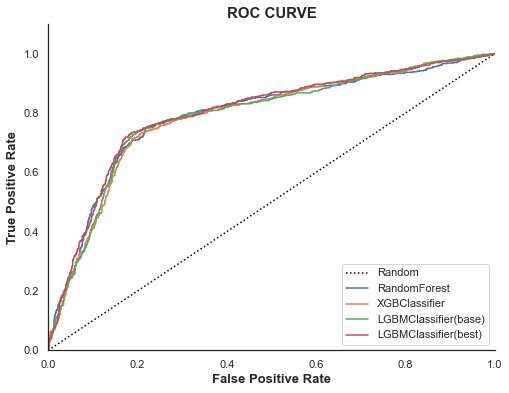

In [18]:
# RandomForest, XGBClassifier, LGBMClassifier(BASELINE), LGBMClassifier(최적화) 모델의 roc_curve를 그려보겠습니다.
# roc_curve 함수는 False Positive Rate, True Positive Rate, Threshold를 반환합니다.
fig, ax = plt.subplots(figsize=(8, 6))
model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)']
random_x = np.linspace(0, 1, 15)
random_y = np.linspace(0, 1, 15)
ax.plot(random_x, random_y, label='Random', color='black', ls=':', lw=1.5)
for pred_proba, model_name in zip(pred_proba_list, model_names):    
    fprs, tprs, _ = roc_curve(tst.target, pred_proba[:, 1])     
    ax.plot(fprs, tprs, label=model_name)    
ax.legend(loc='lower right') # 범례 생성
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.set_title('ROC CURVE', fontsize=15, fontweight='bold')
plt.show()
# ROC-CURVE로 모델의 성능을 비교해봅니다.

In [19]:
# NN 모델
def create_model(trn, numeric, categorical):
    cat_inputs, cat_outputs = [], []
    num_input = layers.Input(shape=(len(numeric), ))
    for col in categorical:
        nunique = trn[col].nunique()    
        embed_dim = int(min(np.ceil(nunique/2), 50))
        cat_input = layers.Input(shape=(1, ))    
        cat_output = layers.Embedding(nunique+1, embed_dim)(cat_input)
        cat_output = layers.SpatialDropout1D(0.3)(cat_output)
        cat_output = layers.Flatten()(cat_output)
        cat_inputs.append(cat_input)
        cat_outputs.append(cat_output)
    x = layers.Concatenate()(cat_outputs + [num_input])    
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(2, activation='softmax')(x)

    model = tf.keras.models.Model([num_input, cat_inputs], output)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy',
        metrics=['acc'])
    return model

In [20]:
trn, tst = load_data()
trn, tst = labelencoder(trn, tst)
features = trn.drop('target', axis=1).columns

# numeric feature는 정규화 합니다.
numeric = ['city_development_index', 'training_hours', 'num_missing']
categorical = list(col for col in trn.columns if col not in numeric and col!='target')
for col in numeric:
    ss = StandardScaler()
    trn[col] = ss.fit_transform(trn[col].values.reshape(-1, 1))
    tst[col] = ss.transform(tst[col].values.reshape(-1, 1))
print(trn.shape, tst.shape)

(19158, 14) (2129, 14)


In [1]:
model = create_model(trn, numeric, categorical)
# 위의 모델은 numric, categorical feature 순으로 데이터를 넣어주어야 한다.
y_trn = to_categorical(trn.target.values)
y_tst = to_categorical(tst.target.values)
ec = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=5)
tf_board = TensorBoard(log_dir='logs', histogram_freq=1, embeddings_freq=1)
history = model.fit(
    [trn[numeric].values, list(trn[col].values for col in categorical)], y_trn,
    epochs=100, verbose=1, batch_size=64, validation_split=0.2, shuffle=False,
#     callbacks=[ec, tf_board]
    callbacks=[ec]
)

NameError: name 'create_model' is not defined

In [ ]:
if len(pred_proba_list)>4:
    pred_proba_list = pred_proba_list[:4]

# NN모델의 예측값을 추가하고
pred_proba_list.append(model.predict([tst[numeric].values, list(tst[col].values for col in categorical)]))
# 총 5가지 모델을 비교
model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)', 'NN']
result = make_result_df(model_names, pred_proba_list)
result

In [ ]:
if len(pred_proba_list)>4:
    pred_proba_list = pred_proba_list[:4]

# NN모델의 예측값을 추가하고
pred_proba_list.append(model.predict([tst[numeric].values, list(tst[col].values for col in categorical)]))
# 총 5가지 모델을 비교
model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)', 'NN']
result = make_result_df(model_names, pred_proba_list)
result

In [ ]:
# NN모델의 예측값을 추가하고
#pred_proba_list.append(model.predict([tst[numeric].values, list(tst[col].values for col in categorical)]))
# 총 5가지 모델을 비교
#model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)', 'NN']
#result = make_result_df(model_names, pred_proba_list)
#result

In [ ]:
# 5개 모델을 ROC_CURVE로 비교합니다.
fig, ax = plt.subplots(figsize=(20, 9))
model_names = ['RandomForest', 'XGBClassifier', 'LGBMClassifier(base)', 'LGBMClassifier(best)', 'NN']
random_x = np.linspace(0, 1, 15)
random_y = np.linspace(0, 1, 15)
ax.plot(random_x, random_y, label='Random', color='black', ls=':', lw=1.5)
for pred_proba, model_name in zip(pred_proba_list, model_names):    
    fprs, tprs, _ = roc_curve(tst.target, pred_proba[:, 1])     
    ax.plot(fprs, tprs, label=model_name)    
ax.legend(loc='lower right') # 범례 생성
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.set_title('ROC CURVE', fontsize=15, fontweight='bold')
plt.show()
# ROC-CURVE로 모델의 성능을 비교해봅니다.

In [ ]:
# !tensorboard --logdir=logs